In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

2023-01-11 15:57:22.735592: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [97]:
raw_data = pd.read_csv('../Data/Processed Data/usable_data.csv')

In [98]:
dataset = raw_data.copy()

In [102]:
X = dataset.drop('Solubility(%)', axis=1)
y = dataset.iloc[:, 0:1]

,Solubility(%)
0,32.0
1,18.0
2,78.0
3,7.0
4,85.0
...,...
3155,98.0
3156,88.0
3157,94.0
3158,69.0


In [103]:
def normalize(col_data):
    return (col_data - col_data.min())/(col_data.max()-col_data.min())

In [104]:
for column in X:
    X[column] = normalize(X[column])
X = round(X,2)

In [105]:
y = round(normalize(y),2)

In [106]:
sample_set = X.copy()
sample_set['Solubility(%)'] = y['Solubility(%)']


sample_set = sample_set[ ['Solubility(%)'] + [ col for col in sample_set.columns if col != 'Solubility(%)' ] ]

In [107]:
train_dataset = sample_set.sample(frac=0.8, random_state=0)
test_dataset = sample_set.drop(train_dataset.index)

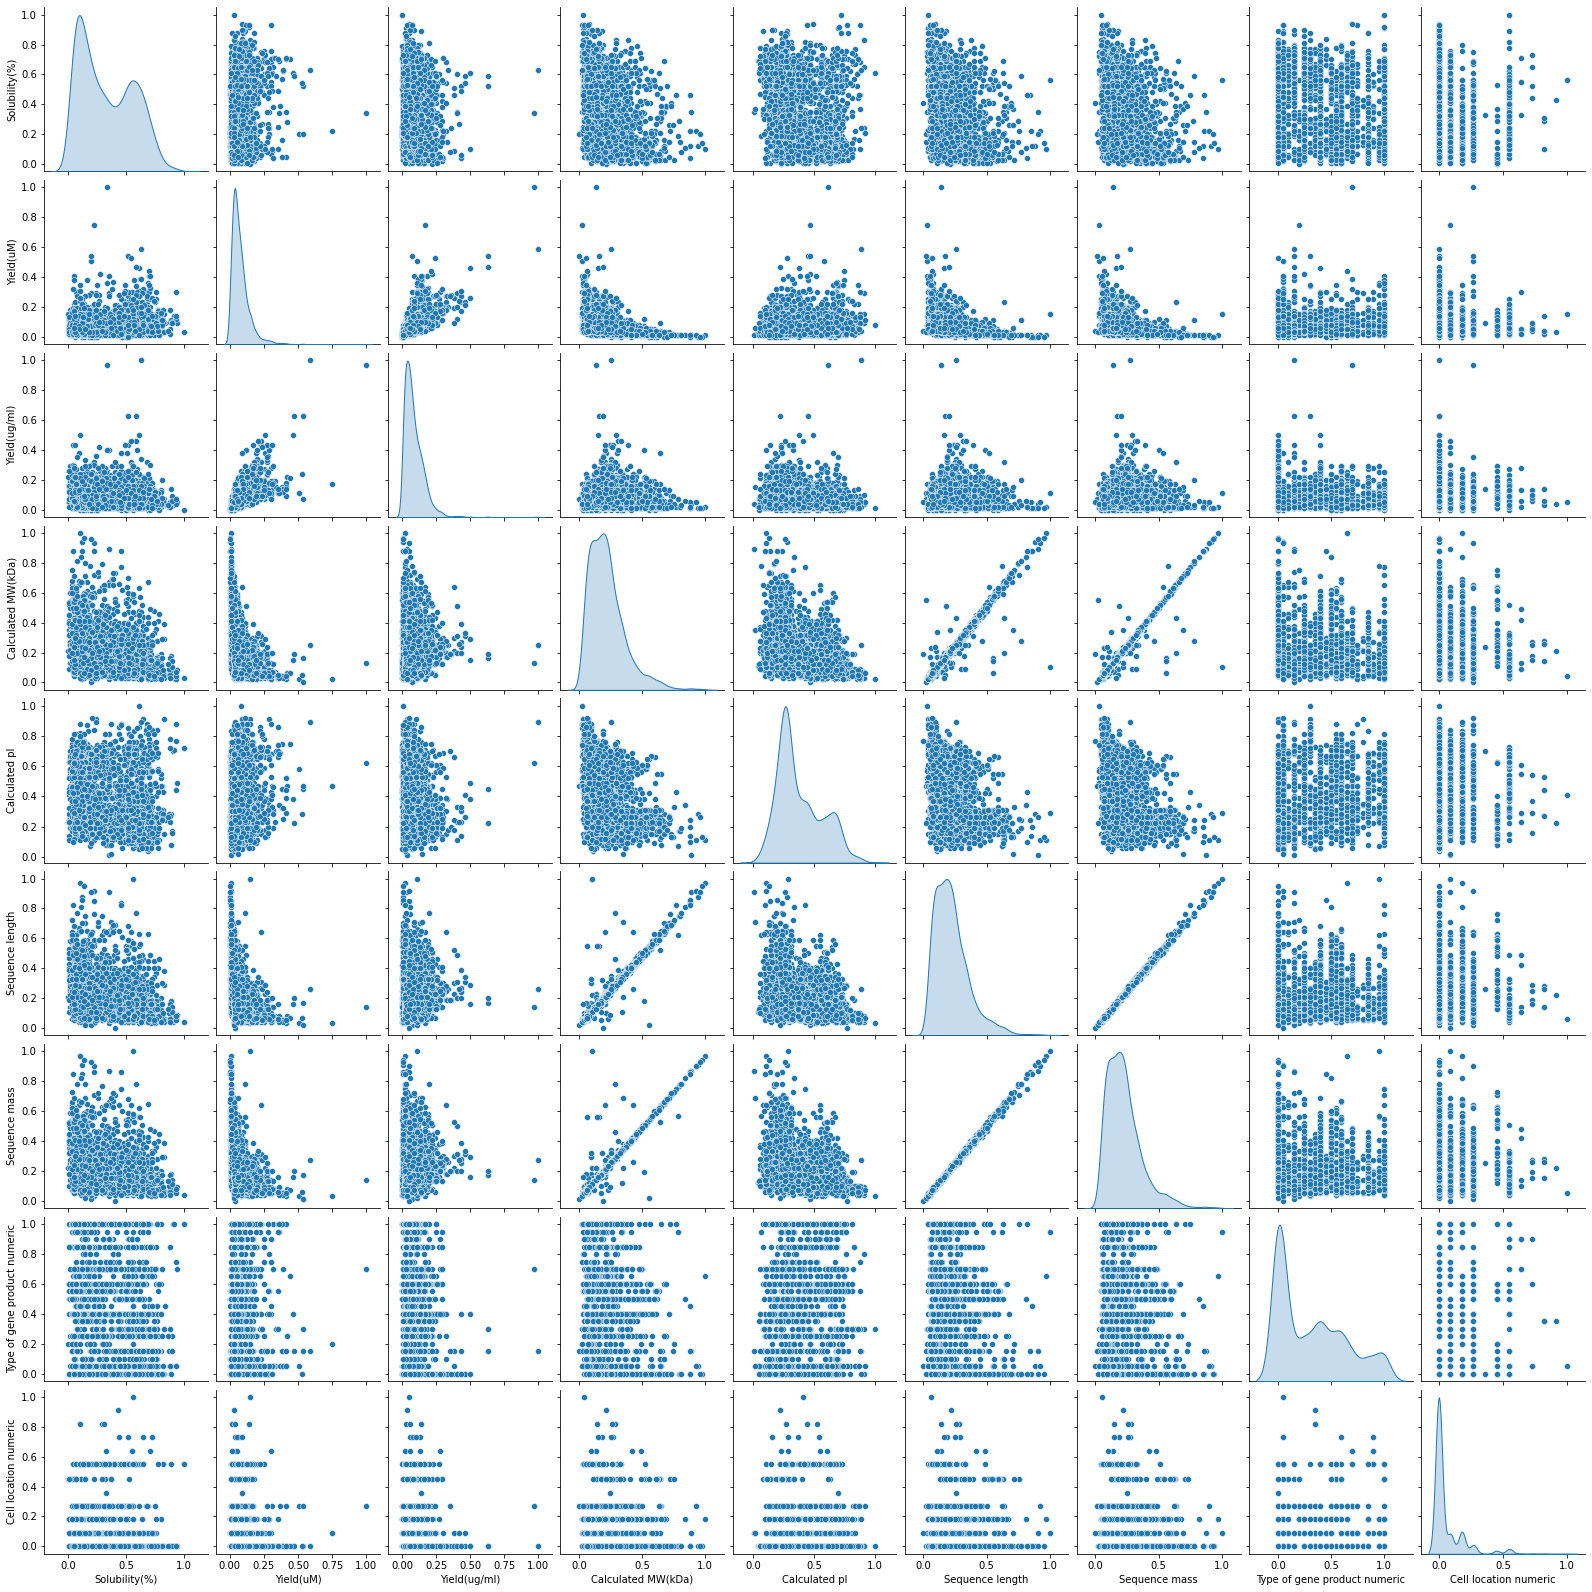

In [108]:
sns.pairplot(train_dataset[train_dataset.columns], diag_kind='kde')

In [109]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Solubility(%),2528.0,0.331555,0.229289,0.00,0.12,0.290,0.54,1.0
Yield(uM),2528.0,0.077271,0.070306,0.00,0.03,0.060,0.10,1.0
Yield(ug/ml),2528.0,0.086222,0.073373,0.00,0.04,0.070,0.12,1.0
Calculated MW(kDa),2528.0,0.219775,0.144568,0.00,0.11,0.195,0.28,1.0
Calculated pI,2528.0,0.380087,0.182407,0.01,0.25,0.320,0.51,1.0
Sequence length,2528.0,0.225127,0.140056,0.00,0.12,0.200,0.29,1.0
Sequence mass,2528.0,0.225578,0.140260,0.00,0.12,0.200,0.29,1.0
Type of gene product numeric,2528.0,0.315882,0.321133,0.00,0.00,0.250,0.55,1.0
Cell location numeric,2528.0,0.060803,0.127485,0.00,0.00,0.000,0.09,1.0


In [110]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Solubility(%)')
test_labels = test_features.pop('Solubility(%)')

In [111]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
Solubility(%),0.331555,0.229289
Yield(uM),0.077271,0.070306
Yield(ug/ml),0.086222,0.073373
Calculated MW(kDa),0.219775,0.144568
Calculated pI,0.380087,0.182407
Sequence length,0.225127,0.140056
Sequence mass,0.225578,0.140260
Type of gene product numeric,0.315882,0.321133
Cell location numeric,0.060803,0.127485


In [112]:
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(train_features)

In [113]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001),  metrics=[tf.keras.metrics.MeanSquaredError(name='MSE'), tf.keras.metrics.RootMeanSquaredError(name='MRSE')])
  return model

In [114]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 8)                17        
 ion)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                576       
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,818
Trainable params: 4,801
Non-trainable params: 17
_________________________________________________________________


In [115]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 12 s, sys: 1.07 s, total: 13.1 s
Wall time: 10 s


In [116]:
test_results = dnn_model.evaluate(test_features, test_labels, verbose=0)

20/20 [==============================] - 0s 1ms/step


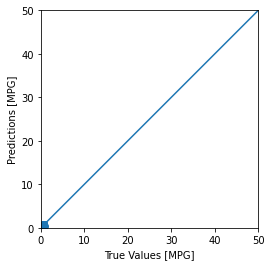

In [117]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


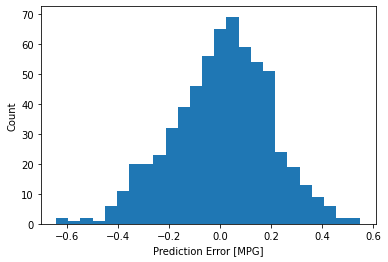

In [118]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [119]:
dnn_model.save('../models/models_DNN')

INFO:tensorflow:Assets written to: ../models/models_DNN/assets


INFO:tensorflow:Assets written to: ../models/models_DNN/assets


In [120]:
test_results

[0.15408840775489807, 0.03759966790676117, 0.19390633702278137]

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8ea8948f-b978-492f-a6dd-8ac5feb4b472' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>